### Домашняя работа №3  «Оценка точности модели, переобучение, регуляризация» обновленное

1. Преобразуйте данные:  
    a. проверьте наличие пропущенных значений. Преобразуйте/удалите пропуски по необходимости;  
    b. закодируйте категориальные переменные числовыми значениями по необходимости.  
2. Разделите выборку на обучающее (80% данных) и тестовое (20% данных) подмножества.
3. Постройте ROC-кривую с помощью функции sklearn.metrics. roc_curve.
4. Вычислите значение ROC-AUC метрики с помощью функции sklearn.metrics.roc_auc_score.
5. Реализуйте подсчет метрик TPR, FPR «вручную», без использования готовых функций из библиотеки sklearn.
6. Постройте ROC-кривую с помощью вычисленных в п. 5 метрик: объедините графики из п. 3 и п. 6 в один. Сравните, сделайте вывод.
7. Постройте график Precision-Recall, используя метрики, посчитанные в п. 5.
8. *Вычислите значение ROC-AUC метрики, используя метрики, посчитанные в п. 5.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, roc_curve, roc_auc_score)

In [2]:
data = pd.read_csv('Downloads/athletes.csv')

In [3]:
display(data.head())
display(data.shape)
data.info()

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0


(11538, 11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11208 non-null  float64
 6   weight       10879 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


In [4]:
data['dob'] = pd.to_datetime(data['dob'])
data['dob'] = np.where(data['dob'].dt.year > 2022, data['dob'] - pd.offsets.DateOffset(years=100), data['dob'])
data['year'] = data['dob'].dt.year

In [5]:
pd.concat([data.isnull().sum().rename('cnt'), round((data.isna().mean() * 100),2).rename('%')], axis=1)

,cnt,%
id,0,0.00
name,0,0.00
nationality,0,0.00
sex,0,0.00
dob,1,0.01
height,330,2.86
weight,659,5.71
sport,0,0.00
gold,0,0.00
silver,0,0.00


In [6]:
data.loc[data['height'].isna(), 'height'] = data.groupby(['nationality', 'sex'])['height'].transform('median')
data.loc[data['weight'].isna(), 'weight'] = data.groupby(['nationality', 'sex'])['weight'].transform('median')
data.dropna(inplace=True)

In [7]:
pd.concat([data.isnull().sum().rename('cnt'), round((data.isna().mean() * 100),2).rename('%')], axis=1)

,cnt,%
id,0,0.0
name,0,0.0
nationality,0,0.0
sex,0,0.0
dob,0,0.0
height,0,0.0
weight,0,0.0
sport,0,0.0
gold,0,0.0
silver,0,0.0


In [8]:
display(data.head())
display(data.shape)
data.info()

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze,year
0,736041664,A Jesus Garcia,ESP,male,1969-10-17,1.72,64.0,athletics,0,0,0,1969.0
1,532037425,A Lam Shin,KOR,female,1986-09-23,1.68,56.0,fencing,0,0,0,1986.0
2,435962603,Aaron Brown,CAN,male,1992-05-27,1.98,79.0,athletics,0,0,1,1992.0
3,521041435,Aaron Cook,MDA,male,1991-01-02,1.83,80.0,taekwondo,0,0,0,1991.0
4,33922579,Aaron Gate,NZL,male,1990-11-26,1.81,71.0,cycling,0,0,0,1990.0


(11476, 12)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11476 entries, 0 to 11537
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           11476 non-null  int64         
 1   name         11476 non-null  object        
 2   nationality  11476 non-null  object        
 3   sex          11476 non-null  object        
 4   dob          11476 non-null  datetime64[ns]
 5   height       11476 non-null  float64       
 6   weight       11476 non-null  float64       
 7   sport        11476 non-null  object        
 8   gold         11476 non-null  int64         
 9   silver       11476 non-null  int64         
 10  bronze       11476 non-null  int64         
 11  year         11476 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(4), object(4)
memory usage: 1.1+ MB


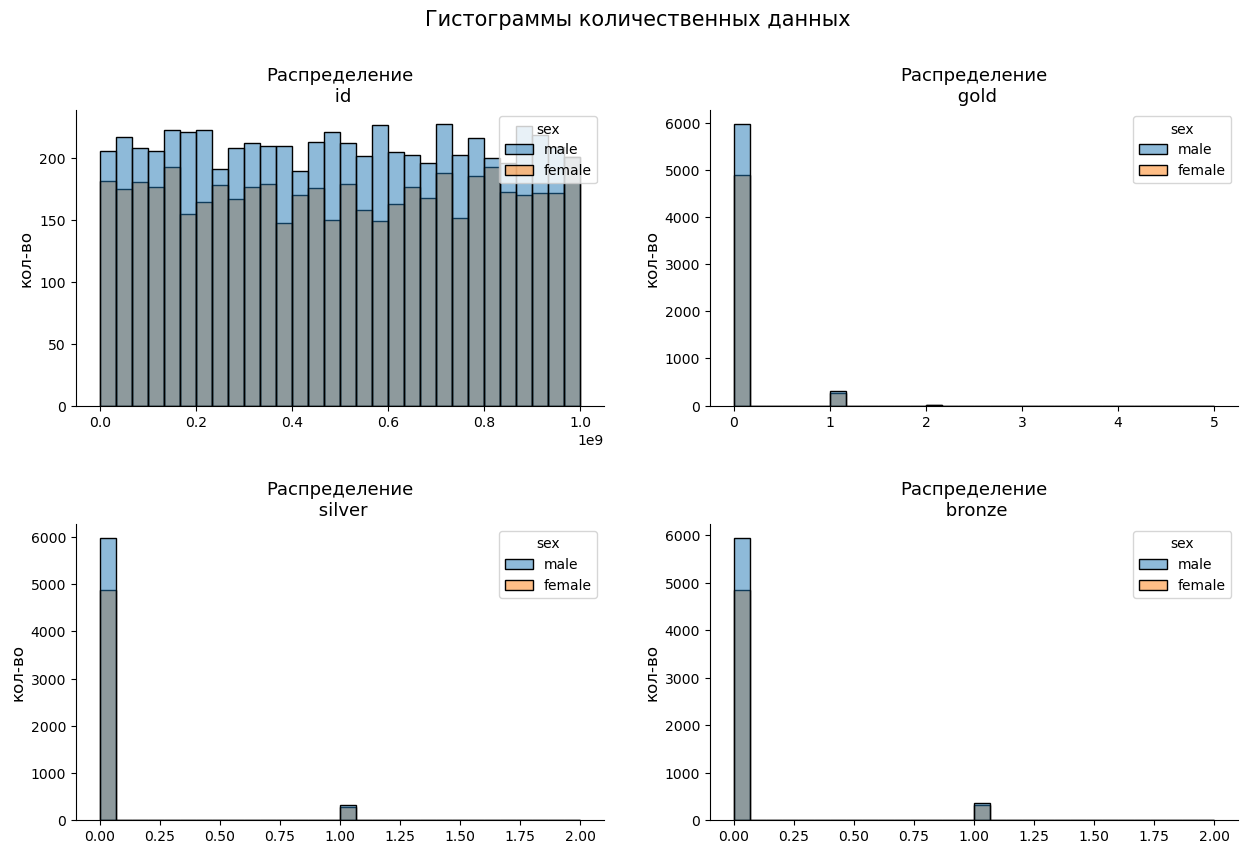

In [9]:
fig = plt.figure(figsize=(15,20))
cols = [k for k,v in data.dtypes.to_dict().items() if v == "int"]
for i,col in enumerate(cols):
    fig.add_subplot(4, 2, i+1)
    sns.histplot(data=data, x=col, hue='sex', kde=False, bins=30)
    plt.title(f'Распределение\n {col}', size=13)
    plt.xlabel('', size=12)
    sns.despine()
    plt.ylabel('кол-во', size=12)
plt.suptitle('Гистограммы количественных данных', size=15, y=0.93)
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()

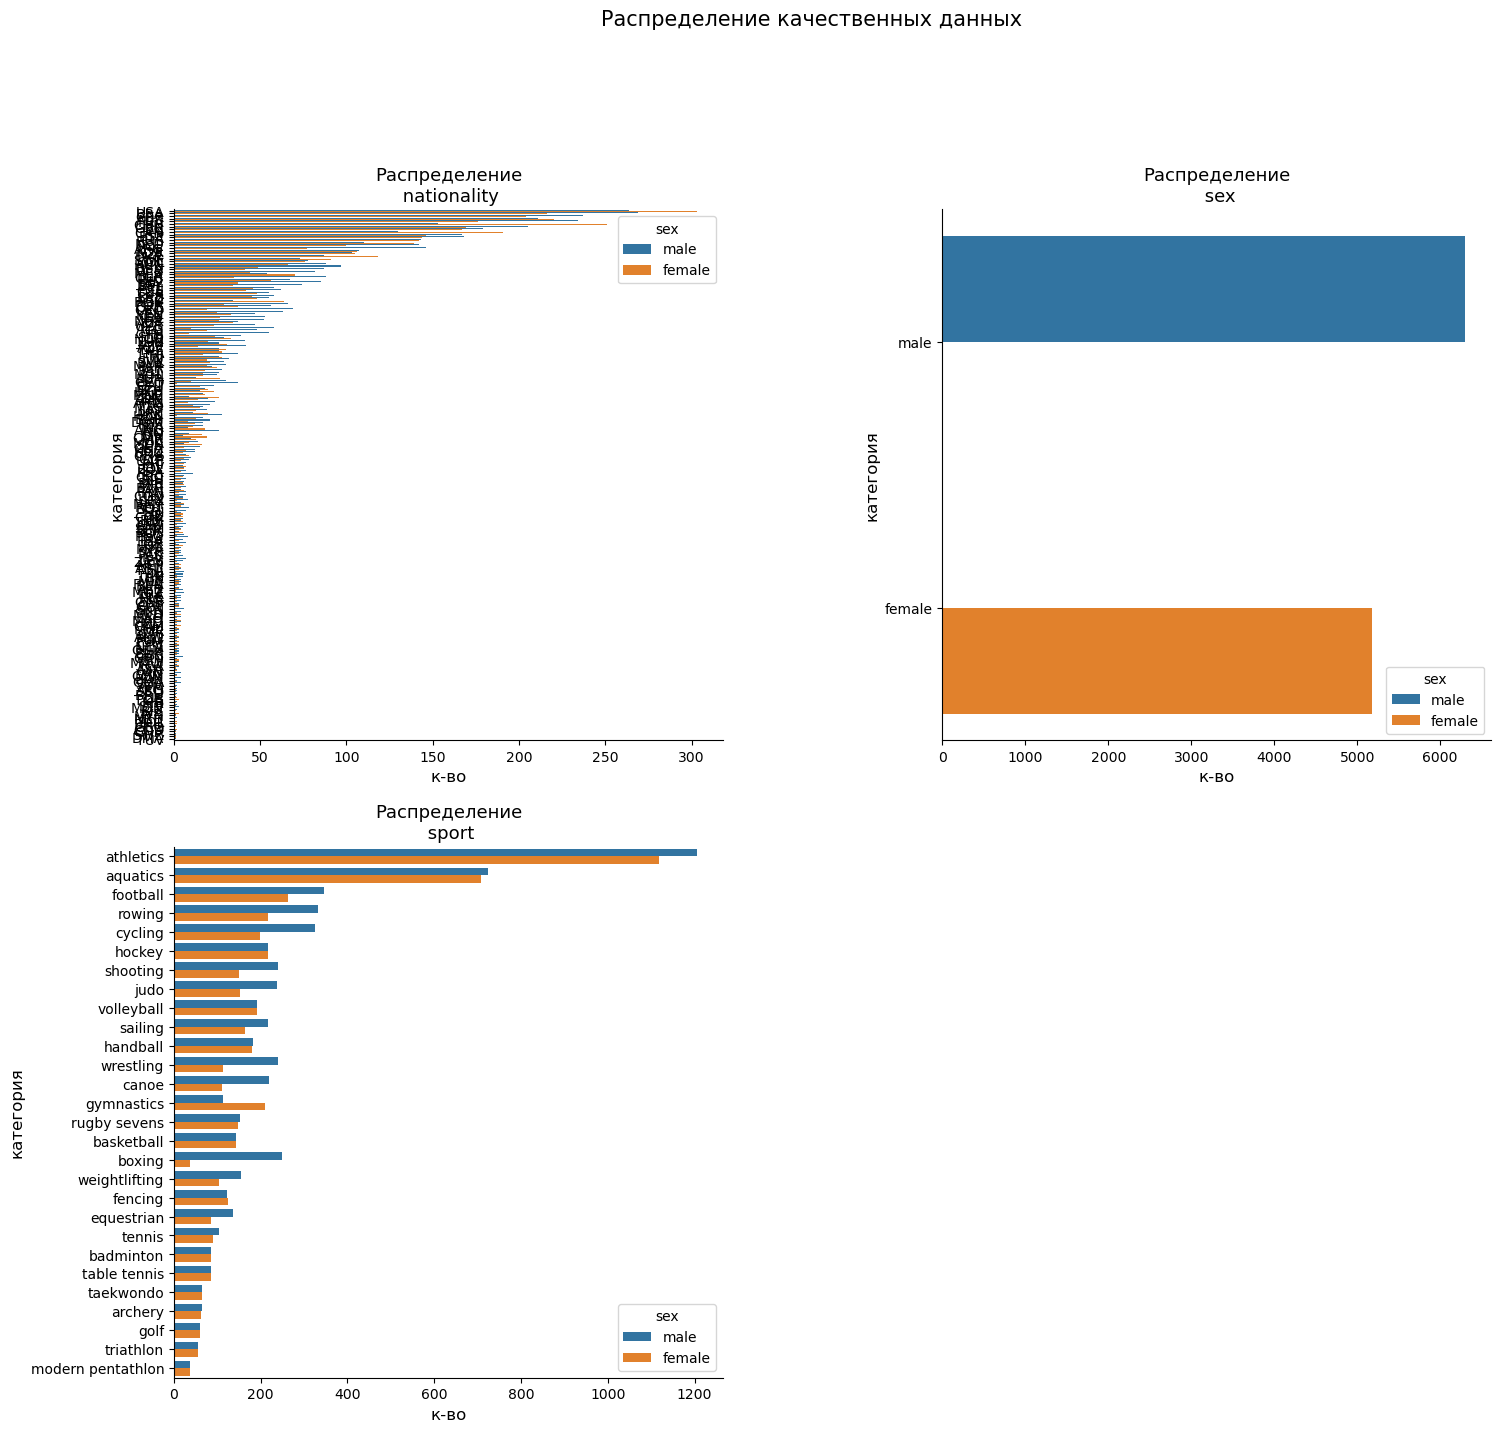

In [10]:
fig = plt.figure(figsize=(17,40))

cols = ['nationality', 'sex', 'sport']
for i,col in enumerate(cols):
    fig.add_subplot(5, 2, i+1)
    sns.countplot(data=data, y=col, order = data[col].value_counts().index, hue='sex', linewidth=1)
    plt.title(f'Распределение\n {col}', size=13)
    plt.xlabel('к-во', size=12)
    sns.despine()
    plt.ylabel('категория', size=12)
plt.suptitle('Распределение качественных данных', size=15, y=0.93)
plt.subplots_adjust(wspace=0.4, hspace=0.2)
plt.show()

In [11]:
data.drop(columns=['id', 'name','dob'], inplace=True)

In [12]:
data = pd.get_dummies(data=data, columns=['sport']).copy()

In [13]:
data['sex'] = data['sex'].map({'male': 0, 'female': 1})

In [14]:
le = LabelEncoder()

In [15]:
for item in [k for k,v in data.dtypes.to_dict().items() if v == "object"]:
    le.fit(data[item])
    data[item] = le.transform(data[item])

In [16]:
display(data.head())
display(data.shape)
# data.info()

,nationality,sex,height,weight,gold,silver,bronze,year,sport_aquatics,sport_archery,...,sport_rugby sevens,sport_sailing,sport_shooting,sport_table tennis,sport_taekwondo,sport_tennis,sport_triathlon,sport_volleyball,sport_weightlifting,sport_wrestling
0,59,0,1.72,64.0,0,0,0,1969.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,101,1,1.68,56.0,0,0,0,1986.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,33,0,1.98,79.0,0,0,1,1992.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,117,0,1.83,80.0,0,0,0,1991.0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,138,0,1.81,71.0,0,0,0,1990.0,0,0,...,0,0,0,0,0,0,0,0,0,0


(11476, 36)

In [17]:
def make_prediction(m, df, target):
    '''
    ФУНКЦИЯ ДЛЯ ПРЕДСКАЗАНИЙ
    ---------------------------
    На вход подается название модели, датафрейм, название столбца с целевой переменной
    Внутри происходит следующее:
    1) Датафрейм делится на признаки и Целевую переменную
    2) Выборка делится на обучающую и валидационную 80/20
    3) Обучающая выборка z преобразуется (средняя=0, std=1)
    4) Обучаем модель на преобразованной выборке
    5) Выдаем тестовый вектора целевой переменной, предсказаний целевой переменной и accuracy на тренировочной и тестовой выборках
    '''
    y = df[target]
    X = df.drop([target], axis = 1) 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    model = m
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_st = scaler.transform(X_train)
    X_test_st = scaler.transform(X_test)
    model.fit(X_train_st, y_train)
    y_pred = model.predict(X_test_st)
    y_prob = model.predict_proba(X_test_st)
    score_train = model.score(X_train_st, y_train)
    return y_test, y_pred, y_prob, score_train

In [18]:
def metrics_dict(*data):
    '''
    ФУНКЦИЯ ДЛЯ РАСЧЕТА МЕТРИК
    ---------------------------
    На вход подаются вектора истиной целевой переменной, 
    предсказанной целевой переменной.
    В результате выводятся: Матрица ошибок, Accuracy, Precision, Recall, F1
    '''
    metrics = {}
    metrics['Accuracy train'] = f'{data[0][3]:.2%}'
    metrics['Accuracy test'] = f'{(accuracy_score(data[0][0], data[0][1])):.2%}'
    metrics['Precision'] = f'{(precision_score(data[0][0], data[0][1])):.2%}'
    metrics['Recall'] = f'{(recall_score(data[0][0], data[0][1])):.2%}'
    metrics['F1'] = f'{(f1_score(data[0][0], data[0][1])):.2%}'
    cm = confusion_matrix(data[0][0], data[0][1])
    tn, fp, fn, tp = cm.ravel()
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Матрица ошибок')
    plt.show()
    print(f'True negative = {tn}\nFalse positive = {fp}\nFalse negative = {fn}\nTrue positive = {tp}')
    display(pd.Series(metrics))

In [19]:
def model_report(model):
    print(model,'\n')
    res = make_prediction(model, data, 'sex')
    metrics_dict(res)

LogisticRegression(class_weight='balanced') 



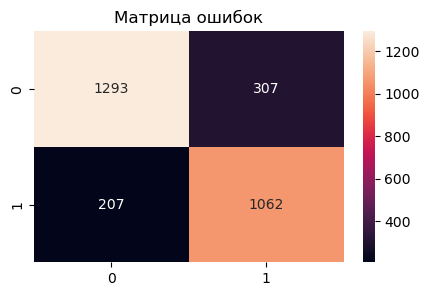

True negative = 1293
False positive = 307
False negative = 207
True positive = 1062


Accuracy train    81.64%
Accuracy test     82.08%
Precision         77.57%
Recall            83.69%
F1                80.52%
dtype: object

In [20]:
model_report(LogisticRegression(class_weight='balanced'))